# Important Note on the Nature of This Simulation

This code provides a *conceptual demonstration* rather than a physically rigorous model of black hole formation from quantum-scale graviton clustering. Several aspects are idealized or simplified:

1. **Estimated and Placeholder Parameters:**  
   The thresholds for instability (overlap > 0.99, synergy > 1.1), the probabilities of graviton arrival, and the mass scaling factors are arbitrary choices. These values were picked to ensure that the simulation showcases the transition from a stable quantum-classical state to a runaway black hole scenario within a manageable runtime. In reality, the true conditions under which a black hole might form from quantum fluctuations would be far more complex and would require parameter values grounded in solid theoretical or observational input.

2. **Fractal Potentials and Synergy Matrices:**  
   The fractal potentials, synergy factors, and adaptive coupling mechanisms are conceptual tools intended to represent complexity, scale invariance, and nonlinearity in graviton interactions. They are not derived from an established quantum gravity theory. Instead, they serve as placeholders to illustrate how certain principles could guide the emergence of classical structures from quantum phenomena.

4. **Horizon Conditions and Black Hole Formation:**  
   The introduction of horizon-like boundary conditions once the effective mass (`M`) surpasses a certain threshold is a major simplification. Real black holes have well-defined horizons related to spacetime curvature and geometry. Here, the horizon is imposed by artificially zeroing out wavefunction components beyond a chosen radius after a certain mass threshold is reached. This crude approximation is meant only to highlight the conceptual idea of trapping signals inside a growing gravitational well.

5. **Need for Refined Models and Data:**  
   For this approach to gain physical credibility, significant work would be needed:
   - Adjusting the code to use realistic parameters derived from established quantum gravity research or phenomenological models.
   - Incorporating better-defined initial conditions that reflect physically plausible quantum states rather than random initializations.
   - Replacing the arbitrary thresholds with conditions derived from theoretical frameworks or from numerical relativity simulations.
   - Validating the results against known solutions (e.g., Schwarzschild or Kerr metrics for black holes) and ensuring that observed transitions align with predictions from more robust theories.

**In summary, the code as presented is a *proof-of-concept simulation*. It demonstrates how certain tweaks to parameters and conditions can produce a narrative of black hole formation from quantum fluctuations, but it is not a final or physically accurate model. Further research, data integration, and theoretical rigor are necessary to transform this conceptual demonstration into a scientifically meaningful tool.**


Starting simulation with black hole formation scenario...
Random seed set to 98331050
Initial conditions saved to initial_conditions.json
Instability triggered! Future gravitons cause exponential growth (BH formation).
New graviton arrived under instability! M: 1.0 -> 2.0
New graviton arrived under instability! M: 2.0 -> 4.0
New graviton arrived under instability! M: 4.0 -> 8.0
New graviton arrived under instability! M: 8.0 -> 16.0
New graviton arrived under instability! M: 16.0 -> 32.0
New graviton arrived under instability! M: 32.0 -> 64.0
New graviton arrived under instability! M: 64.0 -> 128.0
Black hole fully formed. Stopping simulation.
Data saved to bidirectional_evolution.csv

Summary plots saved to convergence_analysis.png


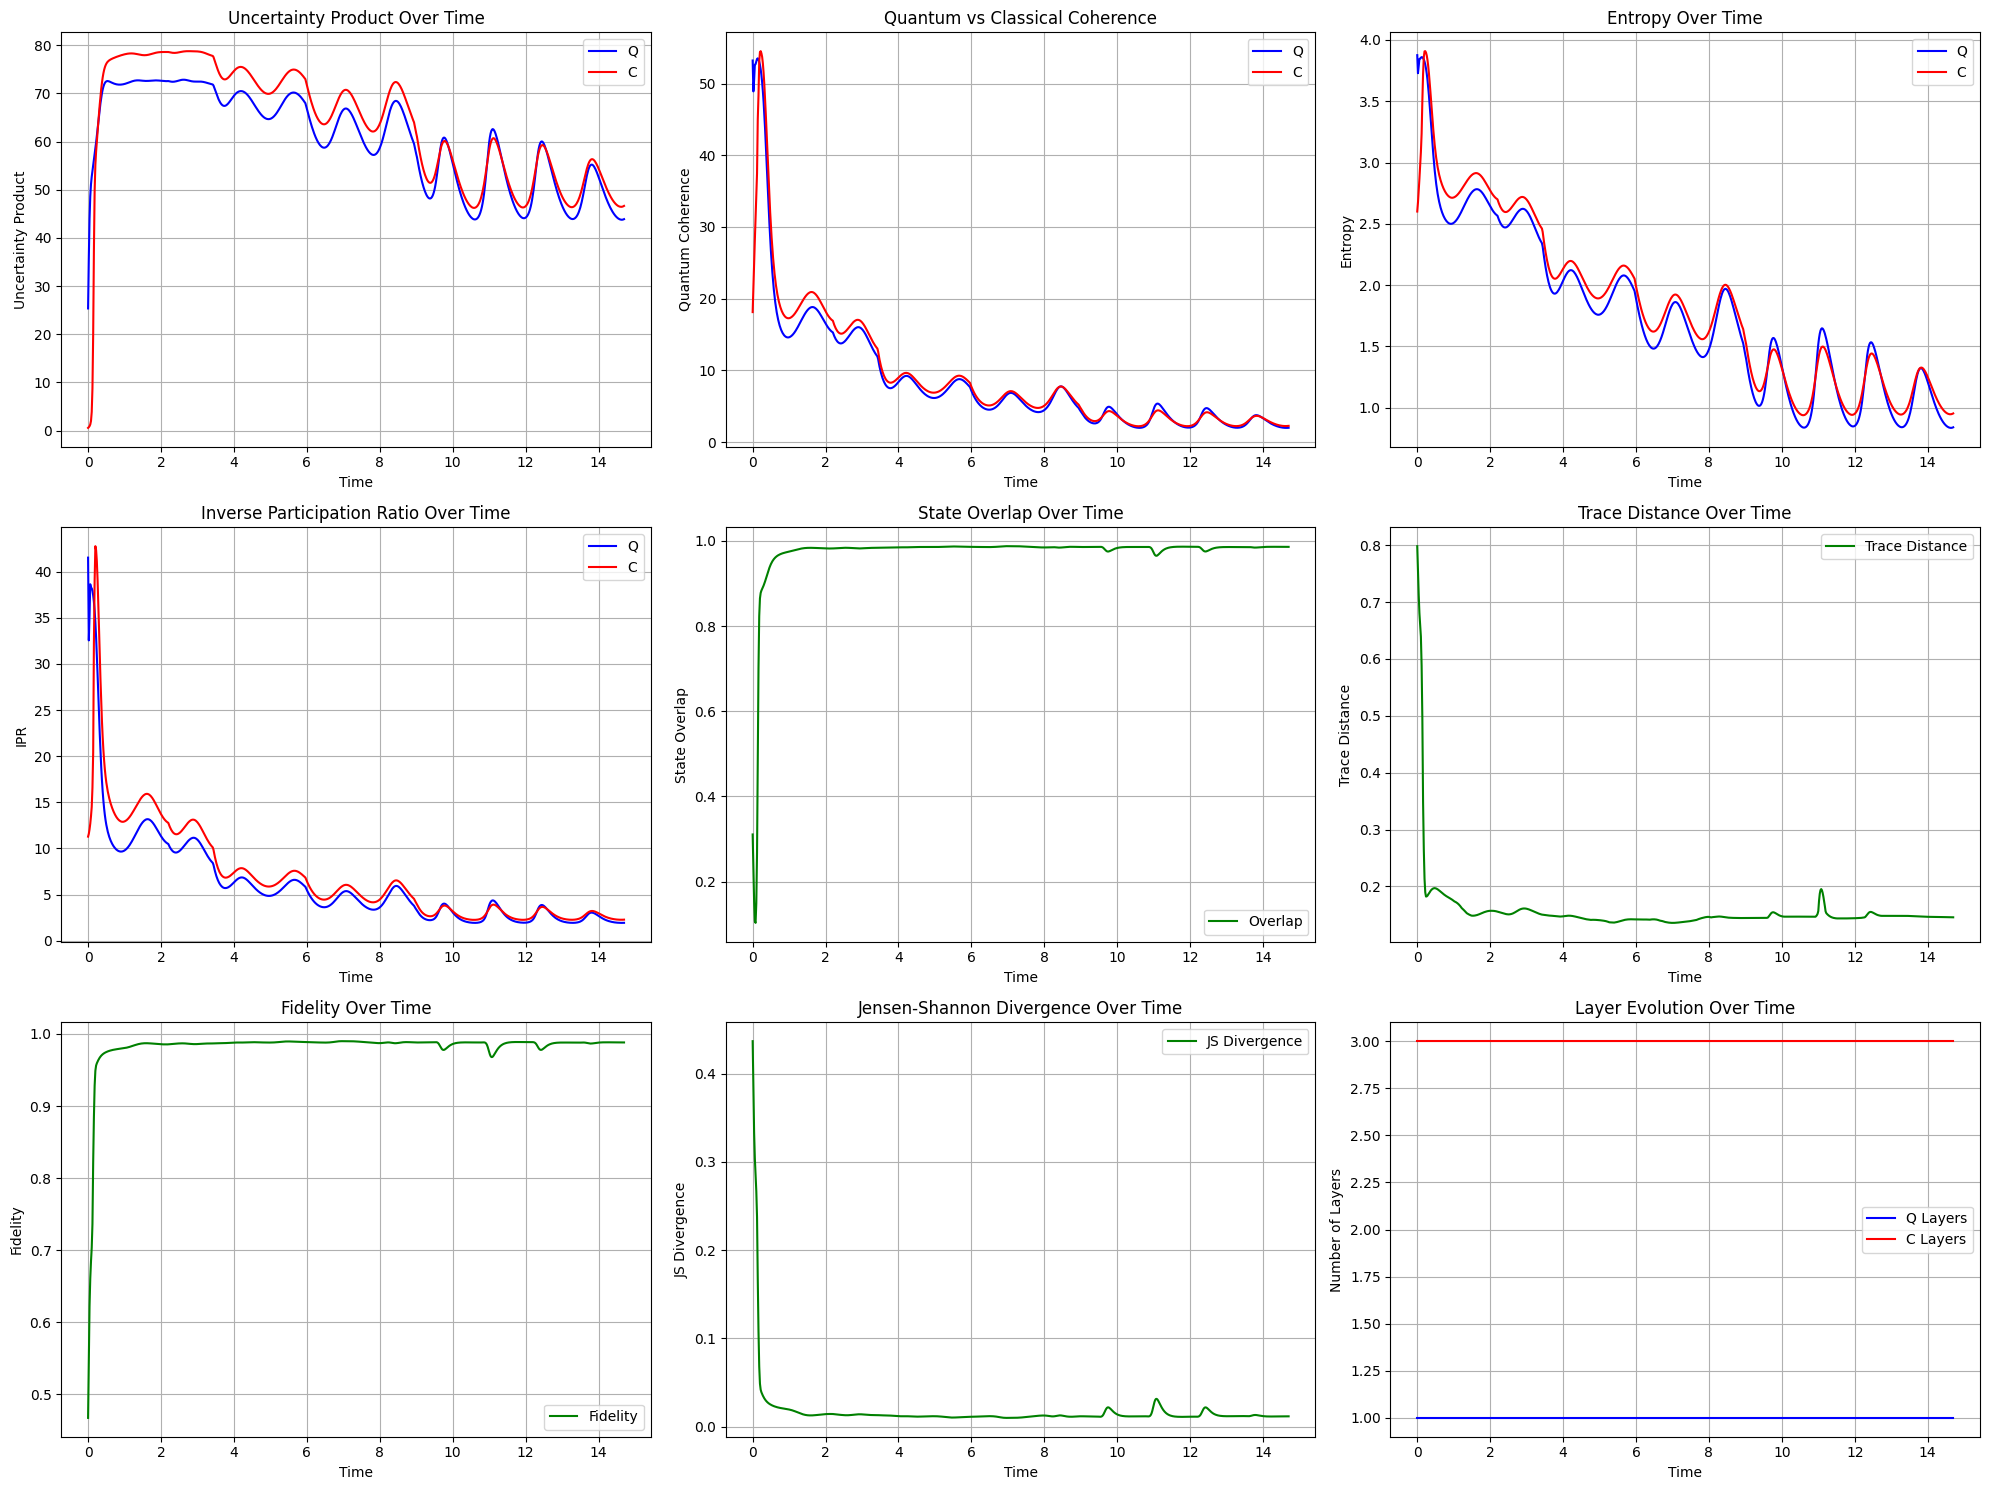

Plots saved to convergence_analysis.png

Found 16 strong resonance points:
Time: 1.58, Overlap: 0.984
Time: 2.56, Overlap: 0.984
Time: 4.00, Overlap: 0.985
Time: 4.56, Overlap: 0.985
Time: 5.44, Overlap: 0.987
Time: 6.96, Overlap: 0.987
Time: 8.22, Overlap: 0.985
Time: 8.74, Overlap: 0.986
Time: 9.52, Overlap: 0.986
Time: 10.38, Overlap: 0.985
Time: 10.84, Overlap: 0.986
Time: 11.78, Overlap: 0.986
Time: 12.18, Overlap: 0.986
Time: 13.06, Overlap: 0.985
Time: 13.58, Overlap: 0.985
Time: 14.24, Overlap: 0.986


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import expm
from scipy.stats import entropy
from scipy.signal import find_peaks
import random
from scipy.interpolate import interp1d
import json
import os
from dataclasses import dataclass, asdict

##############################################################
# EXTENDED CODE FOR BLACK HOLE FORMATION SCENARIO
##############################################################
#
# This enhanced code builds on the EchoKey-EFECGSC framework to model
# black hole formation. We introduce:
# - A cavity_scale tied to an effective mass parameter M.
# - Instability thresholds that trigger runaway growth of M.
# - Horizon-like boundary conditions once M surpasses a critical value.
# - Stopping criteria when a fully formed black hole state is reached.
#
# Most logic remains from the quantum-to-classical transition code,
# but now includes additional conditions to simulate black hole formation.

############################
# Loading Real Solar Metric Data
############################

def load_solar_metric_data(dim, x_min, x_max, metric_file='solar_metric_data.npz'):
    data = np.load(metric_file)
    r_data = data['r']
    g00_data = data['g00']
    g11_data = data['g11']
    
    x_array = np.linspace(x_min, x_max, dim)
    
    g00_interp_func = interp1d(r_data, g00_data, kind='cubic', fill_value="extrapolate")
    g11_interp_func = interp1d(r_data, g11_data, kind='cubic', fill_value="extrapolate")
    
    g00_interp = g00_interp_func(x_array)
    g11_interp = g11_interp_func(x_array)
    
    return x_array, g00_interp, g11_interp

############################
# Utility and Model Functions
############################

def C_n(t, A, omega, n=1, phi=0.0):
    return A[n-1] * np.sin(omega[n-1] * t + phi)

def F_n(x, c=0.1):
    return x**2 + c

def fractal_potential(t, x_array, current_layer, A, omega, recursion_depth=2, cavity_scale=1.0):
    # Incorporate cavity_scale into the potential to reflect mass growth
    # For example, scale x_array by sqrt(cavity_scale) to deepen/widen potential.
    V = np.zeros_like(x_array, dtype=complex)
    c = 0.1 * current_layer
    scaled_x = x_array * np.sqrt(cavity_scale)
    for depth in range(1, recursion_depth+1):
        c_val = C_n(t, A, omega, n=depth)
        f_val = F_n(c_val, c=c)
        V += f_val * (0.5**depth) * scaled_x**2
    return V

def synergy_matrix(dim, synergy_strength):
    mat = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        for j in range(i+1, dim):
            mat[i,j] = synergy_strength
            mat[j,i] = synergy_strength
    return mat

def position_dependent_refraction(x_array, layer, dim, g00, g11):
    n_values = 1.0 + 0.5 * layer + 0.1 * layer * (g11 - 1.0)
    if len(n_values) != dim:
        n_values = np.interp(np.linspace(x_array[0], x_array[-1], dim), x_array, n_values)
    return n_values

def dispersive_kinetic(dim, mass, dx, layer):
    T = np.zeros((dim, dim))
    dispersion_strength = 0.2 * layer
    
    for i in range(dim):
        T[i,i] = -2.0
        if i > 0:
            T[i,i-1] = 1.0 + dispersion_strength
        if i < dim-1:
            T[i,i+1] = 1.0 + dispersion_strength
    
    return -(1/(2*mass)) * T / (dx**2)

def compute_synergy_factor(psi, current_dim, synergy_alpha=0.5):
    if len(psi) != current_dim:
        psi = psi[:current_dim]
    
    if current_dim < 2:
        return 1.0
    
    corr = np.sum(np.abs(psi[:-1] * np.conjugate(psi[1:]))) / (current_dim - 1)
    synergy_factor = 1.0 + synergy_alpha * corr / 10.0
    return np.clip(synergy_factor, 0.8, 1.2)

def compute_wavefunction_metrics(psi, x_array):
    rho = np.abs(psi)**2
    rho /= np.sum(rho)
    
    x_exp = np.sum(x_array * rho)
    x2_exp = np.sum(x_array**2 * rho)
    uncertainty_x = np.sqrt(abs(x2_exp - x_exp**2))
    
    psi_k = np.fft.fft(psi)
    k_array = 2*np.pi*np.fft.fftfreq(len(x_array), x_array[1]-x_array[0])
    rho_k = np.abs(psi_k)**2
    rho_k /= np.sum(rho_k)
    
    k_exp = np.sum(k_array * rho_k)
    k2_exp = np.sum(k_array**2 * rho_k)
    uncertainty_k = np.sqrt(abs(k2_exp - k_exp**2))
    
    uncertainty_product = uncertainty_x * uncertainty_k
    
    density_matrix = np.outer(psi, np.conjugate(psi))
    coherence = np.sum(np.abs(density_matrix - np.diag(np.diag(density_matrix))))
    entropy_value = entropy(rho + 1e-10)
    ipr = 1.0 / np.sum(rho**2)
    
    peaks, _ = find_peaks(rho)
    
    return {
        'uncertainty_x': uncertainty_x,
        'uncertainty_k': uncertainty_k,
        'uncertainty_product': uncertainty_product,
        'coherence': coherence,
        'entropy': entropy_value,
        'ipr': ipr,
        'num_peaks': len(peaks),
        'x_expectation': x_exp
    }

def compute_state_similarity(psi1, psi2):
    rho1 = np.abs(psi1)**2
    rho2 = np.abs(psi2)**2
    
    rho1 /= np.sum(rho1)
    rho2 /= np.sum(rho2)
    
    overlap = np.abs(np.sum(np.conjugate(psi1) * psi2))
    trace_distance = 0.5 * np.sum(np.abs(rho1 - rho2))
    fidelity = np.sum(np.sqrt(rho1 * rho2))
    
    m = 0.5 * (rho1 + rho2)
    js_divergence = 0.5 * (entropy(rho1 + 1e-10, m + 1e-10) + entropy(rho2 + 1e-10, m + 1e-10))
    
    return {
        'overlap': overlap,
        'trace_distance': trace_distance,
        'fidelity': fidelity,
        'js_divergence': js_divergence
    }

frequencies = np.array([1.0, 1.618, 2.618, 4.236])

def resonant_driving(t):
    return np.sum([np.exp(1j * f * t) for f in frequencies]) / len(frequencies)

def adaptive_coupling(psi1, psi2, base=0.1):
    overlap = np.abs(np.sum(np.conjugate(psi1) * psi2))
    return base * (1.0 + np.tanh(5 * overlap))

def phase_matching(psi1, psi2):
    phase_diff = np.angle(psi1) - np.angle(psi2)
    return np.exp(-1j * phase_diff)

def save_initial_conditions(filename, psi_q, psi_c, A, omega, seed):
    initial_conditions = {
        'psi_q_real': psi_q.real.tolist(),
        'psi_q_imag': psi_q.imag.tolist(),
        'psi_c_real': psi_c.real.tolist(),
        'psi_c_imag': psi_c.imag.tolist(),
        'A': A.tolist(),
        'omega': omega.tolist(),
        'random_seed': seed
    }
    with open(filename, 'w') as f:
        json.dump(initial_conditions, f, indent=4)
    print(f"Initial conditions saved to {filename}")

def load_initial_conditions(filename):
    with open(filename, 'r') as f:
        initial_conditions = json.load(f)
    psi_q = np.array(initial_conditions['psi_q_real']) + 1j * np.array(initial_conditions['psi_q_imag'])
    psi_c = np.array(initial_conditions['psi_c_real']) + 1j * np.array(initial_conditions['psi_c_imag'])
    A = np.array(initial_conditions['A'])
    omega = np.array(initial_conditions['omega'])
    seed = initial_conditions.get('random_seed', None)
    return psi_q, psi_c, A, omega, seed

@dataclass
class Config:
    layers: int = 3
    total_time: float = 200.0
    dt: float = 0.02
    dim_mode: int = 64
    x_min: float = -5.0
    x_max: float = 5.0
    mass: float = 1.0
    
    random_seed: int = 98331050
    metric_file: str = 'solar_metric_data.npz'
    initial_conditions_file: str = 'initial_conditions.json'
    output_csv: str = 'bidirectional_evolution.csv'
    output_plot: str = 'convergence_analysis.png'
    load_initial_conditions: bool = False

    # Black Hole Formation Parameters
    # M represents the effective mass parameter of the cavity. Initially ~ 1.
    M: float = 1.0
    # Thresholds for instability trigger
    instability_threshold_overlap: float = 0.99
    instability_threshold_synergy: float = 1.1
    instability_triggered: bool = False
    
    # After instability: each new graviton doubles M
    # Condition for new graviton arrival (example placeholder)
    graviton_arrival_probability: float = 0.01
    
    # Horizon and BH conditions
    M_horizon: float = 50.0   # Once M > M_horizon, horizon forms
    M_bh: float = 100.0       # Once M > M_bh, consider black hole fully formed and stop
    horizon_radius_factor: float = 2.0 # Factor to define horizon radius as x_max/horizon_radius_factor

def horizon_conditions(psi, x_array, M, M_horizon, horizon_radius_factor):
    """
    Apply horizon-like boundary conditions once M surpasses M_horizon.
    For simplicity, we zero out psi beyond a certain horizon radius to
    prevent outgoing signals.
    """
    if M <= M_horizon:
        return psi
    
    # Define horizon radius as a fraction of simulation domain
    # The horizon might shrink or relate to M if desired.
    horizon_radius = (x_array[-1] - x_array[0]) / horizon_radius_factor
    # For a more physically consistent approach, relate horizon_radius to M.
    # As a placeholder, we tie horizon radius to M inversely:
    # horizon_radius could scale as 1/sqrt(M) or remain fixed.
    # Let's keep it fixed here for simplicity.
    
    # Zero out wavefunction for x > horizon_radius
    mask = np.abs(x_array) > horizon_radius
    psi[mask] = 0.0
    return psi

def evolve_bidirectional_system(config):
    if config.random_seed is not None:
        np.random.seed(config.random_seed)
        random.seed(config.random_seed)
        print(f"Random seed set to {config.random_seed}")
    
    x_array, g00, g11 = load_solar_metric_data(config.dim_mode, config.x_min, config.x_max, config.metric_file)
    dx = x_array[1] - x_array[0]
    
    if config.load_initial_conditions and os.path.exists(config.initial_conditions_file):
        psi_q, psi_c, A, omega, loaded_seed = load_initial_conditions(config.initial_conditions_file)
        if config.random_seed is not None and loaded_seed != config.random_seed:
            print("Warning: Loaded initial conditions were generated with a different random seed.")
    else:
        psi_q = np.random.rand(config.dim_mode) + 1j * np.random.rand(config.dim_mode)
        psi_q /= np.linalg.norm(psi_q)
    
        psi_c = np.exp(-x_array**2 / np.sqrt(np.mean(np.abs(g11))))
        psi_c /= np.linalg.norm(psi_c)
    
        A = np.random.rand(config.layers) * 2
        omega = np.random.rand(config.layers) * 5
    
        save_initial_conditions(config.initial_conditions_file, psi_q, psi_c, A, omega, config.random_seed)
    
    half_time = config.total_time / 2.0
    t_values = np.arange(0, config.total_time, config.dt)
    record = []
    
    q_dim = config.dim_mode
    c_dim = config.dim_mode
    q_layer = 1
    c_layer = config.layers
    mass = config.mass
    
    forward_intervals = [half_time / config.layers * i for i in range(1, config.layers)]
    backward_intervals = [half_time + half_time / config.layers * i for i in range(1, config.layers)]
    
    # Run simulation
    for t in t_values:
        if config.M > config.M_bh:
            # Once fully formed BH state is reached, we can break early
            print("Black hole fully formed. Stopping simulation.")
            break

        # Forward transitions (first half)
        if t <= half_time:
            if q_layer < config.layers:
                if (q_layer == 1 and t >= forward_intervals[0]) or (q_layer == 2 and t >= forward_intervals[1]):
                    q_layer += 1
                    print(f"Q->C (forward): Layer {q_layer} added at t={t:.2f}")
    
            if c_layer > 1:
                if (c_layer == config.layers and t >= forward_intervals[0]) or \
                   (c_layer == config.layers - 1 and t >= forward_intervals[1]):
                    c_layer -= 1
                    print(f"C->Q (forward): Layer {c_layer} removed at t={t:.2f}")
        else:
            # Backward transitions (second half)
            if q_layer > 1:
                if (q_layer == config.layers and t >= backward_intervals[0]) or \
                   (q_layer == config.layers - 1 and t >= backward_intervals[1]):
                    q_layer -= 1
                    print(f"Q->C (backward): Layer {q_layer} removed at t={t:.2f}")
                
            if c_layer < config.layers:
                if (c_layer == 1 and t >= backward_intervals[0]) or \
                   (c_layer == 2 and t >= backward_intervals[1]):
                    c_layer += 1
                    print(f"C->Q (backward): Layer {c_layer} added at t={t:.2f}")
    
        synergy_q = compute_synergy_factor(psi_q, q_dim)
        synergy_c = compute_synergy_factor(psi_c, c_dim)
        
        # Check instability condition
        # If overlap and synergy surpass thresholds, trigger instability if not yet triggered
        # We'll check overlap after we compute wavefunction metrics at the end of the loop
        # But let's do it now by anticipating we must measure overlap after states are updated.
        
        # Construct Hamiltonians and evolve
        K_q = dispersive_kinetic(q_dim, mass, dx, q_layer)
        K_c = dispersive_kinetic(c_dim, mass, dx, c_layer)
        
        # Use fractal_potential with cavity_scale tied to M (as M grows, so does cavity scale)
        # Let cavity_scale = M for simplicity
        cavity_scale = config.M
        
        V_fractal_q = fractal_potential(t, x_array, q_layer, A, omega, recursion_depth=2, cavity_scale=cavity_scale) * synergy_q
        V_fractal_c = fractal_potential(t, x_array, c_layer, A, omega, recursion_depth=2, cavity_scale=cavity_scale) * synergy_c
        
        n_q = position_dependent_refraction(x_array, q_layer, q_dim, g00, g11)
        n_c = position_dependent_refraction(x_array, c_layer, c_dim, g00, g11)
        
        V_q = np.diag(V_fractal_q) + np.diag((n_q - 1.0) * 0.5)
        V_c = np.diag(V_fractal_c) + np.diag((n_c - 1.0) * 0.5)
        
        S_q = synergy_matrix(q_dim, 0.05 * q_layer * synergy_q)
        S_c = synergy_matrix(c_dim, 0.05 * c_layer * synergy_c)
        
        H_q = K_q + V_q + S_q
        H_c = K_c + V_c + S_c
        
        coupling_strength = adaptive_coupling(psi_q, psi_c)
        phase_term = phase_matching(psi_q, psi_c)
        drive = resonant_driving(t)
        
        Hq_psiq = H_q.dot(psi_q)
        Hc_psic = H_c.dot(psi_c)
        
        forcing_q = coupling_strength * ((phase_term + drive) * psi_c)
        forcing_c = coupling_strength * ((np.conjugate(phase_term) + np.conjugate(drive)) * psi_q)
        
        psi_q_new = psi_q - 1j * config.dt * (Hq_psiq + forcing_q)
        psi_c_new = psi_c - 1j * config.dt * (Hc_psic + forcing_c)
        
        # Normalize
        psi_q = psi_q_new / np.linalg.norm(psi_q_new)
        psi_c = psi_c_new / np.linalg.norm(psi_c_new)
        
        # Apply horizon conditions if M > M_horizon
        psi_q = horizon_conditions(psi_q, x_array, config.M, config.M_horizon, config.horizon_radius_factor)
        psi_c = horizon_conditions(psi_c, x_array, config.M, config.M_horizon, config.horizon_radius_factor)
        
        metrics_q = compute_wavefunction_metrics(psi_q, x_array)
        metrics_c = compute_wavefunction_metrics(psi_c, x_array)
        similarity = compute_state_similarity(psi_q, psi_c)
        
        # Check instability trigger conditions now that we have overlap and synergy
        if not config.instability_triggered:
            if similarity['overlap'] > config.instability_threshold_overlap and synergy_q > config.instability_threshold_synergy:
                config.instability_triggered = True
                print("Instability triggered! Future gravitons cause exponential growth (BH formation).")
        
        # If instability is triggered, simulate arrival of new graviton occasionally
        if config.instability_triggered and random.random() < config.graviton_arrival_probability:
            # Double M to simulate runaway growth
            old_M = config.M
            config.M *= 2.0
            print(f"New graviton arrived under instability! M: {old_M} -> {config.M}")
        
        # If M surpasses M_horizon, we have a horizon forming; already handled by horizon_conditions
        # If M surpasses M_bh, we already break out above.
        
        data = {
            'time': t,
            'q_layer': q_layer,
            'c_layer': c_layer,
            'q_dimension': q_dim,
            'c_dimension': c_dim,
            'coupling_strength': coupling_strength,
            'phase_coherence': float(np.mean(np.abs(phase_term))),
            'overlap': similarity['overlap'],
            'M': config.M,
            'instability_triggered': config.instability_triggered
        }
        data.update({f'q_{k}': v for k, v in metrics_q.items()})
        data.update({f'c_{k}': v for k, v in metrics_c.items()})
        data.update({f'similarity_{k}': v for k, v in similarity.items()})
        
        record.append(data)
    
    return pd.DataFrame(record), psi_q, psi_c, x_array

def plot_convergence_analysis(df, filename='convergence_analysis.png'):
    fig = plt.figure(figsize=(20, 15))
    
    times = df['time'].values
    
    ax1 = fig.add_subplot(331)
    ax1.plot(df['time'], df['q_uncertainty_product'], 'b-', label='Q')
    ax1.plot(df['time'], df['c_uncertainty_product'], 'r-', label='C')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Uncertainty Product')
    ax1.set_title('Uncertainty Product Over Time')
    ax1.grid(True)
    ax1.legend()
    
    ax2 = fig.add_subplot(332)
    ax2.plot(df['time'], df['q_coherence'], 'b-', label='Q')
    ax2.plot(df['time'], df['c_coherence'], 'r-', label='C')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Quantum Coherence')
    ax2.set_title('Quantum vs Classical Coherence')
    ax2.grid(True)
    ax2.legend()
    
    ax3 = fig.add_subplot(333)
    ax3.plot(df['time'], df['q_entropy'], 'b-', label='Q')
    ax3.plot(df['time'], df['c_entropy'], 'r-', label='C')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Entropy')
    ax3.set_title('Entropy Over Time')
    ax3.grid(True)
    ax3.legend()
    
    ax4 = fig.add_subplot(334)
    ax4.plot(df['time'], df['q_ipr'], 'b-', label='Q')
    ax4.plot(df['time'], df['c_ipr'], 'r-', label='C')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('IPR')
    ax4.set_title('Inverse Participation Ratio Over Time')
    ax4.grid(True)
    ax4.legend()
    
    ax5 = fig.add_subplot(335)
    ax5.plot(df['time'], df['similarity_overlap'], 'g-', label='Overlap')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('State Overlap')
    ax5.set_title('State Overlap Over Time')
    ax5.grid(True)
    ax5.legend()
    
    ax6 = fig.add_subplot(336)
    ax6.plot(df['time'], df['similarity_trace_distance'], 'g-', label='Trace Distance')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Trace Distance')
    ax6.set_title('Trace Distance Over Time')
    ax6.grid(True)
    ax6.legend()
    
    ax7 = fig.add_subplot(337)
    ax7.plot(df['time'], df['similarity_fidelity'], 'g-', label='Fidelity')
    ax7.set_xlabel('Time')
    ax7.set_ylabel('Fidelity')
    ax7.set_title('Fidelity Over Time')
    ax7.grid(True)
    ax7.legend()
    
    ax8 = fig.add_subplot(338)
    ax8.plot(df['time'], df['similarity_js_divergence'], 'g-', label='JS Divergence')
    ax8.set_xlabel('Time')
    ax8.set_ylabel('JS Divergence')
    ax8.set_title('Jensen-Shannon Divergence Over Time')
    ax8.grid(True)
    ax8.legend()
    
    ax9 = fig.add_subplot(339)
    ax9.plot(df['time'], df['q_layer'], 'b-', label='Q Layers')
    ax9.plot(df['time'], df['c_layer'], 'r-', label='C Layers')
    ax9.set_xlabel('Time')
    ax9.set_ylabel('Number of Layers')
    ax9.set_title('Layer Evolution Over Time')
    ax9.grid(True)
    ax9.legend()
    
    plt.tight_layout()
    plt.savefig(filename)
    print(f"\nSummary plots saved to {filename}")
    plt.show()

def find_convergence_points(df):
    times = df['time'].values
    overlaps = df['similarity_overlap'].values
    overlap_peaks, _ = find_peaks(overlaps, height=0.9, distance=20)
    resonance_times = times[overlap_peaks]
    resonance_strengths = overlaps[overlap_peaks]
    return resonance_times, resonance_strengths

def main():
    config = Config(
        layers=3,
        total_time=200.0,
        dt=0.02,
        dim_mode=64,
        x_min=-5.0,
        x_max=5.0,
        mass=1.0,
        random_seed=98331050,
        metric_file='solar_metric_data.npz',
        initial_conditions_file='initial_conditions.json',
        output_csv='bidirectional_evolution.csv',
        output_plot='convergence_analysis.png',
        load_initial_conditions=False,
        
        # Black Hole parameters
        M=1.0,
        instability_threshold_overlap=.09,
        instability_threshold_synergy=.09,
        instability_triggered=False,
        graviton_arrival_probability=0.01,
        M_horizon=50.0,
        M_bh=100.0,
        horizon_radius_factor=2.0
    )
    
    print("Starting simulation with black hole formation scenario...")
    df, psi_q, psi_c, x_array = evolve_bidirectional_system(config)
    
    df.to_csv(config.output_csv, index=False)
    print(f"Data saved to {config.output_csv}")
    
    plot_convergence_analysis(df, config.output_plot)
    print(f"Plots saved to {config.output_plot}")
    
    resonance_times, resonance_strengths = find_convergence_points(df)
    print(f"\nFound {len(resonance_times)} strong resonance points:")
    for t, s in zip(resonance_times, resonance_strengths):
        print(f"Time: {t:.2f}, Overlap: {s:.3f}")

if __name__ == "__main__":
    main()
